#### Word2Vec-Skipgram-Tensor(NCE_loss)

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

tf.reset_default_graph()

# 3 Words Sentence
sentences = [ "i like dog", "i like cat", "i like animal",
              "dog cat animal", "apple cat dog like", "dog fish milk like",
              "dog cat eyes like", "i like apple", "apple i hate",
              "apple i movie book music like", "cat dog hate", "cat dog like"]

word_sequence = " ".join(sentences).split()
word_list = " ".join(sentences).split()
word_list = list(set(word_list))
word_dict = {w: i for i, w in enumerate(word_list)}

# Word2Vec Parameter
batch_size = 20
embedding_size = 2 # To show 2 dim embedding graph
num_sampled = 10 # for negative sampling, less than batch_size
voc_size = len(word_list)

W0603 13:46:40.051671 24104 __init__.py:308] Limited tf.compat.v2.summary API due to missing TensorBoard installation.


In [2]:
#Random method 
def random_batch(data, size):
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(data)), size, replace=False)

    for i in random_index:
        random_inputs.append(data[i][0])  # target
        random_labels.append([data[i][1]])  # context word

    return random_inputs, random_labels

# Make skip gram of one size window
skip_grams = []
for i in range(1, len(word_sequence) - 1):
    target = word_dict[word_sequence[i]]
    context = [word_dict[word_sequence[i - 1]], word_dict[word_sequence[i + 1]]]

    for w in context:
        skip_grams.append([target, w])

# Model
inputs = tf.placeholder(tf.int32, shape=[batch_size])
labels = tf.placeholder(tf.int32, shape=[batch_size, 1]) # To use tf.nn.nce_loss, [batch_size, 1]

embeddings = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
selected_embed = tf.nn.embedding_lookup(embeddings, inputs)

nce_weights = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
nce_biases = tf.Variable(tf.zeros([voc_size]))

# Loss and optimizer
cost = tf.reduce_mean(tf.nn.nce_loss(nce_weights, nce_biases, labels, selected_embed, num_sampled, voc_size))
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

W0603 13:47:16.983290 24104 deprecation.py:323] From C:\Users\Kunal\Anaconda3\envs\gputest\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch: 1000 cost = 4.971655
Epoch: 2000 cost = 2.936917
Epoch: 3000 cost = 2.964174
Epoch: 4000 cost = 2.738227
Epoch: 5000 cost = 2.929332


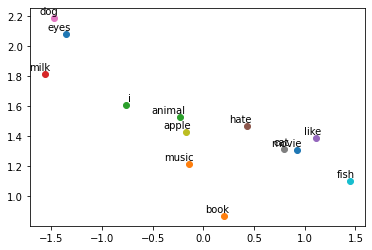

In [3]:
# Training
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    for epoch in range(5000):
        batch_inputs, batch_labels = random_batch(skip_grams, batch_size)
        _, loss = sess.run([optimizer, cost], feed_dict={inputs: batch_inputs, labels: batch_labels})

        if (epoch + 1) % 1000 == 0:
            print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    trained_embeddings = embeddings.eval()

for i, label in enumerate(word_list):
    x, y = trained_embeddings[i]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()

#### Word2Vec_Skipgram_Tensor(Softmax)

In [4]:
#import packages
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

tf.reset_default_graph()

# 3 Words Sentence
sentences = [ "i like dog", "i like cat", "i like animal",
              "dog cat animal", "apple cat dog like", "dog fish milk like",
              "dog cat eyes like", "i like apple", "apple i hate",
              "apple i movie book music like", "cat dog hate", "cat dog like"]

word_sequence = " ".join(sentences).split()
word_list = " ".join(sentences).split()
word_list = list(set(word_list))
word_dict = {w: i for i, w in enumerate(word_list)}

# Word2Vec Parameter
batch_size = 20
embedding_size = 2 # To show 2 dim embedding graph
voc_size = len(word_list)

In [5]:
def random_batch(data, size):
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(data)), size, replace=False)

    for i in random_index:
        random_inputs.append(np.eye(voc_size)[data[i][0]])  # target
        random_labels.append(np.eye(voc_size)[data[i][1]])  # context word

    return random_inputs, random_labels

# Make skip gram of one size window
skip_grams = []
for i in range(1, len(word_sequence) - 1):
    target = word_dict[word_sequence[i]]
    context = [word_dict[word_sequence[i - 1]], word_dict[word_sequence[i + 1]]]

    for w in context:
        skip_grams.append([target, w])

# Model
inputs = tf.placeholder(tf.float32, shape=[None, voc_size])
labels = tf.placeholder(tf.float32, shape=[None, voc_size])

# W and WT is not Traspose relationship
W = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
WT = tf.Variable(tf.random_uniform([embedding_size, voc_size], -1.0, 1.0))

hidden_layer = tf.matmul(inputs, W) # [batch_size, embedding_size]
output_layer = tf.matmul(hidden_layer, WT) # [batch_size, voc_size]

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=output_layer, labels=labels))
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

Epoch: 1000 cost = 2.213470
Epoch: 2000 cost = 2.148885
Epoch: 3000 cost = 2.043902
Epoch: 4000 cost = 1.829578
Epoch: 5000 cost = 2.158406


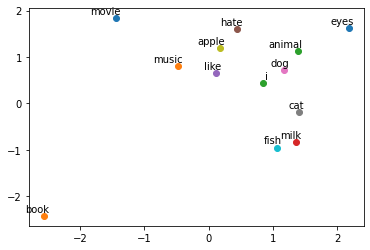

In [6]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    for epoch in range(5000):
        batch_inputs, batch_labels = random_batch(skip_grams, batch_size)
        _, loss = sess.run([optimizer, cost], feed_dict={inputs: batch_inputs, labels: batch_labels})

        if (epoch + 1)%1000 == 0:
            print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

        trained_embeddings = W.eval()

for i, label in enumerate(word_list):
    x, y = trained_embeddings[i]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()

#### Word2Vec_Skipgram_Torch(Softmax)

In [7]:
#import
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt

dtype = torch.FloatTensor

# 3 Words Sentence
sentences = [ "i like dog", "i like cat", "i like animal",
              "dog cat animal", "apple cat dog like", "dog fish milk like",
              "dog cat eyes like", "i like apple", "apple i hate",
              "apple i movie book music like", "cat dog hate", "cat dog like"]

word_sequence = " ".join(sentences).split()
word_list = " ".join(sentences).split()
word_list = list(set(word_list))
word_dict = {w: i for i, w in enumerate(word_list)}

# Word2Vec Parameter
batch_size = 20  # To show 2 dim embedding graph
embedding_size = 2  # To show 2 dim embedding graph
voc_size = len(word_list)

In [8]:
#batch 
def random_batch(data, size):
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(data)), size, replace=False)

    for i in random_index:
        random_inputs.append(np.eye(voc_size)[data[i][0]])  # target
        random_labels.append(data[i][1])  # context word

    return random_inputs, random_labels

# Make skip gram of one size window
skip_grams = []
for i in range(1, len(word_sequence) - 1):
    target = word_dict[word_sequence[i]]
    context = [word_dict[word_sequence[i - 1]], word_dict[word_sequence[i + 1]]]

    for w in context:
        skip_grams.append([target, w])

In [9]:
# Model
class Word2Vec(nn.Module):
    def __init__(self):
        super(Word2Vec, self).__init__()

        # W and WT is not Traspose relationship
        self.W = nn.Parameter(-2 * torch.rand(voc_size, embedding_size) + 1).type(dtype) # voc_size > embedding_size Weight
        self.WT = nn.Parameter(-2 * torch.rand(embedding_size, voc_size) + 1).type(dtype) # embedding_size > voc_size Weight

    def forward(self, X):
        # X : [batch_size, voc_size]
        hidden_layer = torch.matmul(X, self.W) # hidden_layer : [batch_size, embedding_size]
        output_layer = torch.matmul(hidden_layer, self.WT) # output_layer : [batch_size, voc_size]
        return output_layer

model = Word2Vec()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch: 1000 cost = 2.187087
Epoch: 2000 cost = 2.248243
Epoch: 3000 cost = 2.112088
Epoch: 4000 cost = 1.766610
Epoch: 5000 cost = 1.962735


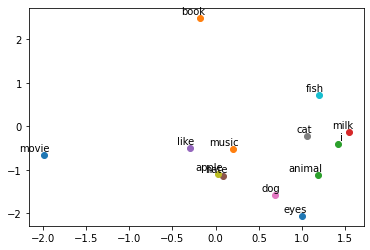

In [10]:
# Training
for epoch in range(5000):

    input_batch, target_batch = random_batch(skip_grams, batch_size)

    input_batch = Variable(torch.Tensor(input_batch))
    target_batch = Variable(torch.LongTensor(target_batch))

    optimizer.zero_grad()
    output = model(input_batch)

    # output : [batch_size, voc_size], target_batch : [batch_size] (LongTensor, not one-hot)
    loss = criterion(output, target_batch)
    if (epoch + 1)%1000 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    loss.backward()
    optimizer.step()

for i, label in enumerate(word_list):
    W, WT = model.parameters()
    x,y = float(W[i][0]), float(W[i][1])
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()